# SDE Models

**Mohan Wu, Martin Lysy -- University of Waterloo**

**December 10, 2022**

## Summary
In this tutorial, we show a simple example for setting up a SDE model for which **PFJAX** can be used to find the marginal likelihoods for the parameters of the SDE.

## Example: Lotka–Volterra Equations
Consider the following Lotka-Volterra model on the log-scale

$$
\begin{aligned}
\exp(x_0) &\sim \pi(x_0) \\
H_t &\sim \N(H_{t-1} + (\alpha - \beta \exp(L_t) dt, \sigma_H^2 dt) \\
L_t &\sim \N(L_{t-1} + (-\gamma + \delta \exp(H_{t-1})) dt, \sigma_L^2 dt) \\
x_t &= (H_t, L_t) \\
y_t &\sim \N(\exp(x_t), \diag(\tau_H^2, \tau_L^2))
\end{aligned}
$$

The parameters of the model are $\theta = (\alpha, \beta, \gamma, \delta, \sigma_H, \sigma_L, \tau_H, \tau_L)$.

In [7]:
# jax
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
from functools import partial
# plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import projplot as pjp
# pfjax
import pfjax as pf
import pfjax.sde as sde
# 64-bit computation
from jax.config import config
config.update("jax_enable_x64", True)

### Initialization

You can define the model based on the base SDEModel class for which many general methods are already implemented. You may notice the API is very similar to that of the `pfjax.BaseModel`. There is however two new arguments: `n_res`, and `diff_diag`.
`n_res` denotes the resolution for which you would like the particle solution to solve at. That is given `dt` and `n_res`, the underlying step size is then `dt/n_res`. Since the observations are fixed and therefore `dt` is fixed, we allow `n_res` to change as to decrease step size. `diff_diag=True` allows for a more computationally efficient algorithm for diagonal variances. We also offer `diff_diag=False` for dense a variance matrix.

### Necessary Methods

The following methods are required: `drift`, `diff`, `meas_{lpdf/sample}`, and `pf_init`. For SDE models, the `drift` and `diffusion` functions are required. In this example, the drift is the mean of Equation (1) and the diffusion is the variance. The `meas_{lpdf/sample}` methods are used to compute the log-density and sample from the measurements given the latents at each time step. Finally, `pf_init` is the initial importance sampler of


In [8]:
class LotVolModel(sde.SDEModel):
    r"""
    Lotka-Volterra predator-prey model.

    Args:
        dt: SDE interobservation time.
        n_res: SDE resolution number.  There are `n_res` latent variables per observation, equally spaced with interobservation time `dt/n_res`.
    """

    def __init__(self, dt, n_res):
        super().__init__(dt, n_res, diff_diag=True)
        self._n_state = (self._n_res, 2) # 2 variables: H, L

    def drift(self, x, theta):
        r"""
        Calculates the SDE drift function.
        """
        alpha = theta[0]
        beta = theta[1]
        gamma = theta[2]
        delta = theta[3]
        return jnp.array([alpha - beta * jnp.exp(x[1]),
                          -gamma + delta * jnp.exp(x[0])])

    def diff(self, x, theta):
        r"""
        Calculates the SDE diffusion function.
        """
        return theta[4:6]

    def meas_lpdf(self, y_curr, x_curr, theta):
        r"""
        Log-density of `p(y_curr | x_curr, theta)`.

        Args:
            y_curr: Measurement variable at current time `t`.
            x_curr: State variable at current time `t`.
            theta: Parameter value.

        Returns:
            The log-density of `p(y_curr | x_curr, theta)`.
        """
        tau = theta[6:8]
        return jnp.sum(
            jsp.stats.norm.logpdf(y_curr,
                                  loc=jnp.exp(x_curr[-1]), scale=tau)
        )

    def meas_sample(self, key, x_curr, theta):
        r"""
        Sample from `p(y_curr | x_curr, theta)`.

        Args:
            key: PRNG key.
            x_curr: State variable at current time `t`.
            theta: Parameter value.

        Returns:
            Sample of the measurement variable at current time `t`: `y_curr ~ p(y_curr | x_curr, theta)`.
        """
        tau = theta[6:8]
        return jnp.exp(x_curr[-1]) + \
            tau * random.normal(key, (self._n_state[1],))

    def pf_init(self, key, y_init, theta):
        r"""
        Importance sampler for `x_init`.  

        See file comments for exact sampling distribution of `p(x_init | y_init, theta)`, i.e., we have a "perfect" importance sampler with `logw = CONST(theta)`.

        Args:
            key: PRNG key.
            y_init: Measurement variable at initial time `t = 0`.
            theta: Parameter value.

        Returns:

            Tuple:

            - x_init: A sample from the proposal distribution for `x_init`.
            - logw: The log-weight of `x_init`.
        """
        tau = theta[6:8]
        key, subkey = random.split(key)
        x_init = jnp.log(y_init + tau * random.truncated_normal(
            subkey,
            lower=-y_init/tau,
            upper=jnp.inf,
            shape=(self._n_state[1],)
        ))
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init/tau))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + x_init.shape),
                       jnp.expand_dims(x_init, axis=0), axis=0), \
            logw

### Simulate Data

This is accomplished with the function `pfjax.simulate()`.

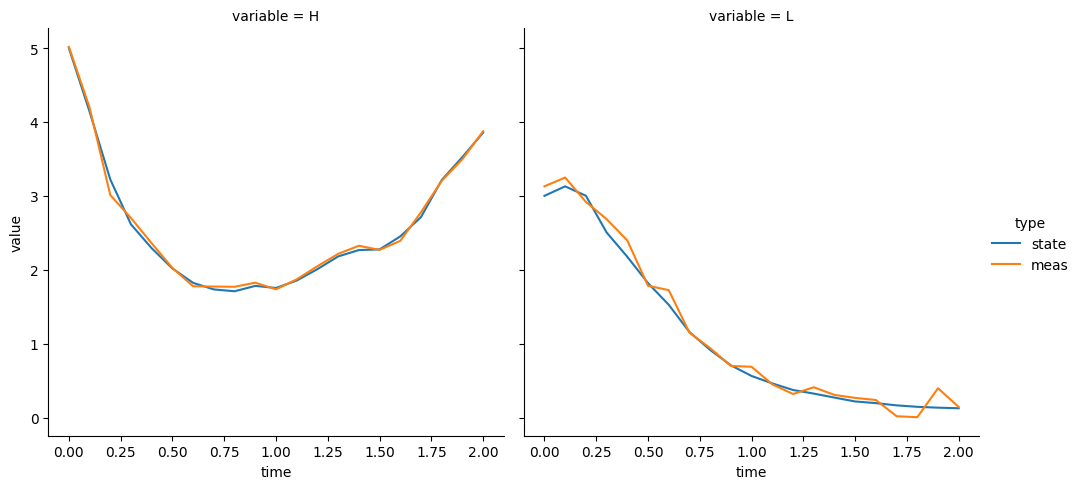

In [10]:
# parameter values
alpha = 1.0
beta = 1.0
gamma = 4.0
delta = 1.0
sigma_h = 0.1
sigma_l = 0.1
tau_h = 0.1
tau_l = 0.1
theta_true = jnp.array([alpha, beta, gamma, delta, sigma_h, sigma_l, tau_h, tau_l])

# data specification
dt = 0.1
n_res = 4
n_obs = 21
x_init = jnp.block([[jnp.zeros((n_res-1, 2))],
                    [jnp.log(jnp.array([5., 3.]))]])


# initial key for random numbers
key = jax.random.PRNGKey(0)

# simulate data
lotvol_model = LotVolModel(dt, n_res) 
key, subkey = jax.random.split(key)

y_meas, x_state = pf.simulate(
    model=lotvol_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta_true
)
# # plot data
df = pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                    "H_state": jnp.squeeze(jnp.exp(x_state[:, (n_res-1)::n_res, 0])),
                    "H_meas": jnp.squeeze(y_meas[:, 0]),
                    "L_state": jnp.squeeze(jnp.exp(x_state[:, (n_res-1)::n_res, 1])),
                    "L_meas": jnp.squeeze(y_meas[:, 1])
                    })
df.set_index('time', inplace=True)
df.columns = pd.MultiIndex.from_tuples(tuple(df.columns.str.split("_")))
df["time"] = df.index
df = df.melt(id_vars=[("time", "")], var_name=["variable", "type"])
plot_df = df.rename(columns={('time', ''):"time"})                   
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type", col="variable"
)

### Calculate Particle Filter Marginal Logikelihood

For this we will use the basic particle filter provided by `pfjax.particle_filter()`.

2.06 s ± 97.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.13 ms ± 443 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


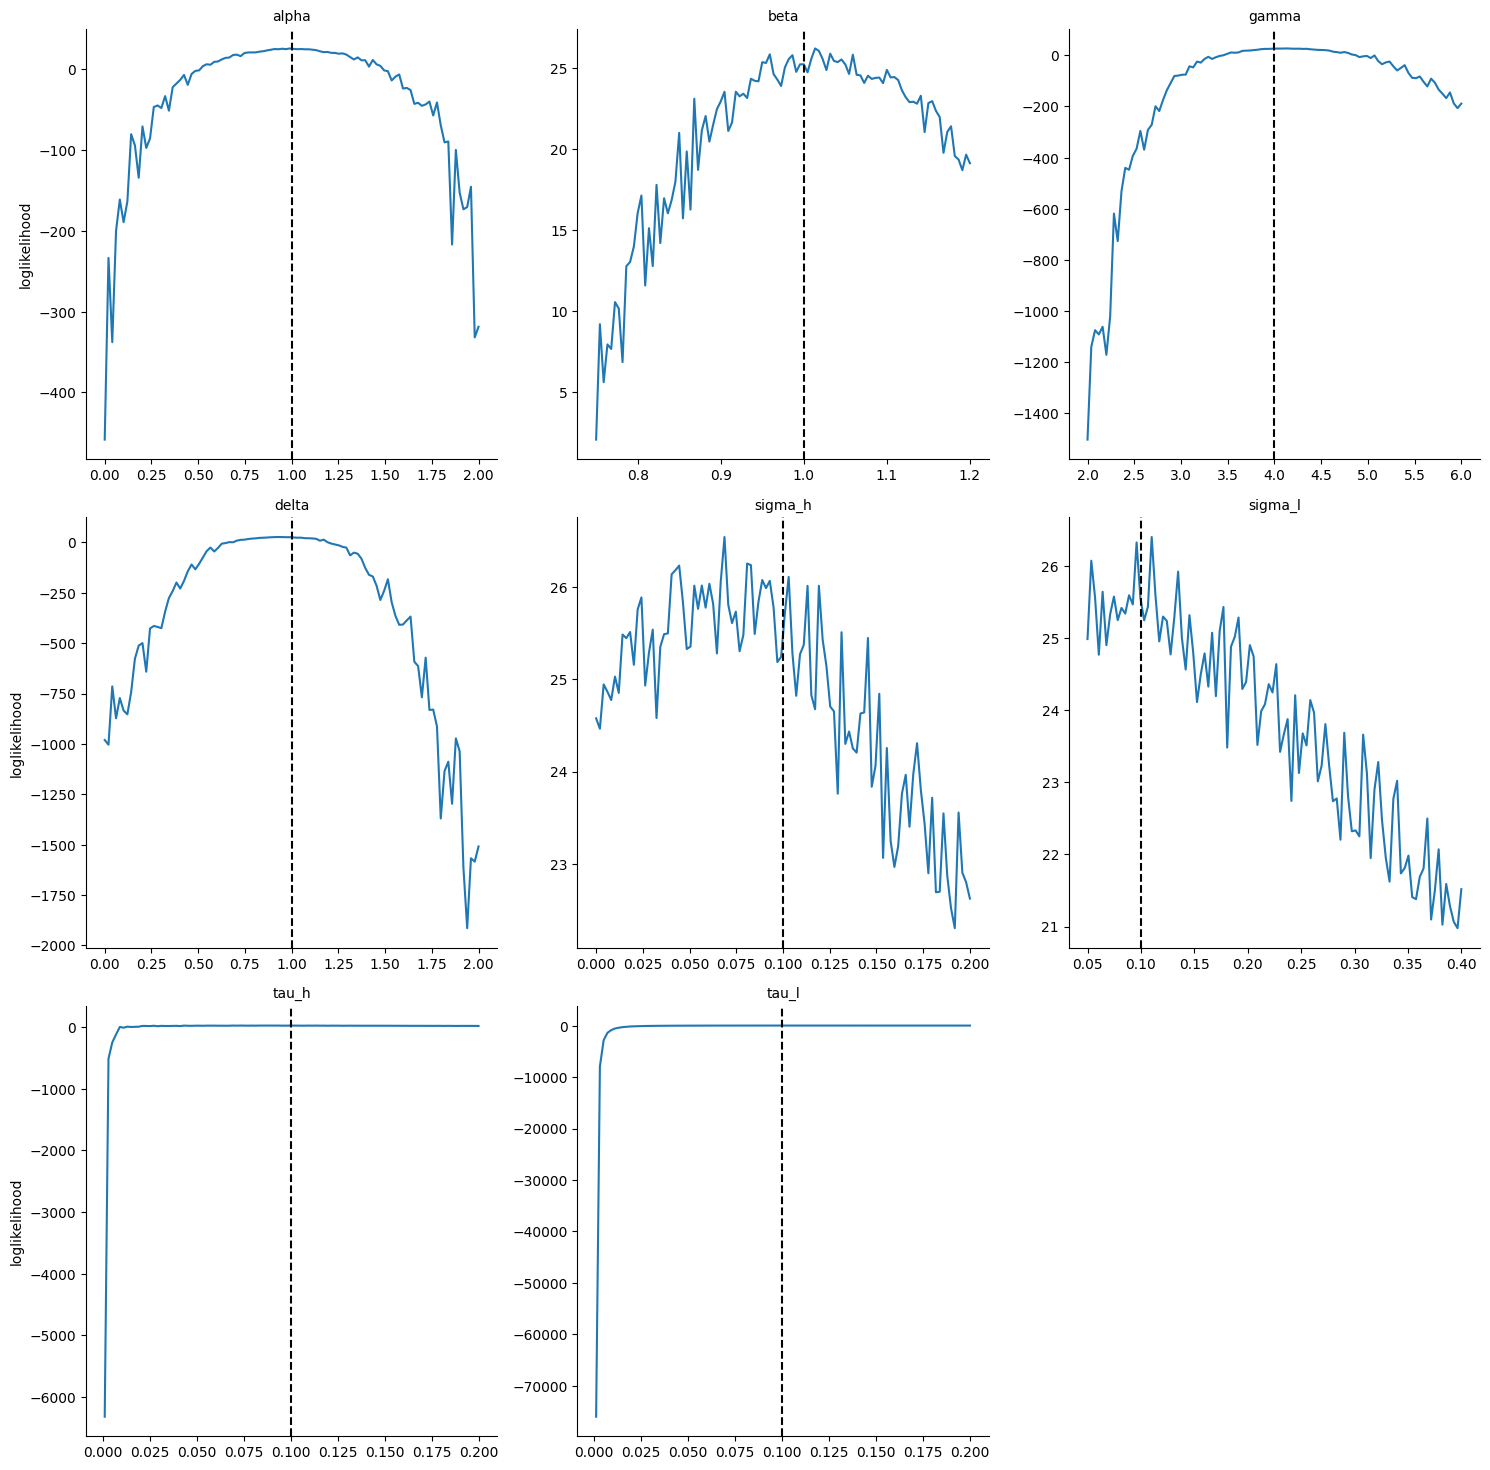

In [13]:
# particle filter specification
n_particles = 200  # number of particles

def lv_loglik_pf_nojit(theta, key):
    """
    Particle filter loglikelihood of the LV model (un-jitted).
    """
    theta = jnp.atleast_2d(theta)
    subkeys = jax.random.split(key, num=theta.shape[0])
    return jax.vmap(lambda _theta, _key: pf.particle_filter(
        model=lotvol_model,
        key=_key,
        y_meas=y_meas,
        n_particles=n_particles,
        theta=_theta,
        history=False,
        score=False,
        fisher=False
    )["loglik"])(theta, subkeys)


# jitted version
lv_loglik_pf_jit = jax.jit(lv_loglik_pf_nojit)

# check jit speedup
key, subkey = jax.random.split(key)
%timeit lv_loglik_pf_nojit(theta=theta_true, key=subkey)
%timeit lv_loglik_pf_jit(theta=theta_true, key=subkey)

# projection plot specification
n_pts = 100  # number of evaluation points per plot
# plot limits for each parameter
theta_lims = np.array([[0., 2.], [.75, 1.2], [2.0, 6.0], [0., 2.],
                       [.000001, .2], [.05, .4], [.001, .2], [.001, .2]])
theta_names = ["alpha", "beta", "gamma", "delta",
               "sigma_h", "sigma_l", "tau_h", "tau_l"]

# calculate projection plot for particle filter loglikelihood
plot_df = pjp.proj_plot(
    fun=partial(lv_loglik_pf_jit, key=subkey),
    x_opt=theta_true,
    x_lims=theta_lims,
    x_names=theta_names,
    n_pts=n_pts,
    vectorized=True,
    plot=False
)

# merge data frames and plot them
plot_df = plot_df.rename(columns={"y": "loglikelihood"})
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="loglikelihood",
    col="variable",
    col_wrap=3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.set_titles(col_template="{col_name}")
rp.set(xlabel=None)
# add true parameter values
for ax, theta in zip(rp.axes.flat, theta_true):
    ax.axvline(theta, linestyle="--", color="black")

### Results

We see that the particle filter correctly computes the maximum loglikelihood at the ground truth for all the parameters except $\tau$. One possible reason is that it is hard to distinguish between $\sigma$ and $\tau$ in Equation (1) as they are both noise terms. The particle filter seems to have assigned all the noise to $\sigma$ leaving $\tau$ to be obsolete. However, it does a good job for the parameters part of the drift function.